# Cle Elum Ridge (CER) Treatment Manuscript Scripts 
## `6_svd_steven_edits.ipynb` 
### Making some changes and final figures to build on Steven's SVD Notebook

**Env**: I was using env `rasterio`, and everything was good except the scalebar addition Steven beautifully created.\
So, now I made a copy of `rasterio` called `rasterio_scalebar` which I then pip installed `matplotlib-scalebar`\
That seems to work, so let's proceed...

In [1]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
# from matplotlib_scalebar.scalebar import ScaleBar

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

import geopandas as gpd
# import rasterio as rio
# from rasterio.warp import calculate_default_transform, reproject, Resampling
# import rioxarray
import rasterio
# import rasterstats
import scipy

# import plotly.express as px

from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker

In [2]:
# !pip install matplotlib-scalebar

In [3]:
from matplotlib_scalebar.scalebar import ScaleBar

In [4]:
# ds = xr.open_dataset('~/RAPID/cer_treatment_region_dataset_all_variables/cer_treatment_region_dataset_all_variables.nc') # Steven's path
ds = xr.open_dataset('C:\\Users\\Lumbr\\OneDrive - UW/Documents\\Washington\\EasternCascades\\Python\\CER_treatment_manuscript\\cer_treatment_region_dataset_all_variables.nc') 

---

In [5]:
ds

<xarray.Dataset>
Dimensions:                           (x: 2564, y: 1388, band: 1)
Coordinates:
  * x                                 (x) float64 4.65e+05 ... 4.676e+05
  * y                                 (y) float64 2.111e+05 ... 2.097e+05
  * band                              (band) int32 1
    spatial_ref                       int32 ...
Data variables: (12/337)
    chmws_rapid                       (band, y, x) float32 ...
    dce_rapid                         (band, y, x) float32 ...
    giulia_dce_rapid                  (band, y, x) float32 ...
    giulia_dce_ncalm                  (band, y, x) float32 ...
    slope                             (band, y, x) float32 ...
    aspect                            (band, y, x) float32 ...
    ...                                ...
    hs_rapid_baf_new_100s_n           (band, y, x) float32 ...
    hs_rapid_baf_new_30s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_60s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_80s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_90s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_100s_s           (band, y, x) float32 ...

In [16]:
# Constants 
# define path to save the figures to
figure_path = "C:\\Users\\Lumbr\\OneDrive - UW\\Documents - mountainhydro\\People\\CassieLumbrazo\\EasternCascades\\Writing\\5_Manuscript\\2_PostDefense\\python_figures\\"

# colors
colorpre='darkslategray'
colorpos='royalblue'
# colorpos='mediumvioletred'

colorsouth = 'darkorange'
colornorth = 'darkblue'

### Compute Standardized Depth Values (SDV)

We want to compare maps of snow depth on two different years, but rather than compare their depths directly, we will use a standardized depth value (SDV). SDV relates how snow depth in a single pixel or point relates to the mean and standard deviation of snow depths throughout the study area. In this way we can see how a single pixel relates to the snow depths in the study area in year 1, then again in year 2, and see if there was a significant change.

Because we anticipate snow depths changing due to changes in forest structure, we should use the mean and standard deviation of the "control" areas where no human-made forest structure change occurred. Additionally, areas with a snow depth of 0 do not provide us with any information (we don't know how snow in that pixel related to the snow depths across the rest of the study area) and therefore should be removed. Areas with a snow depth of 0 in either year should be removed from *both* years so that we can directly compare changes in pairs of pixels with information in both years.

We can then look at histogram or CDF plots to see how distribution of SDV changed between the two years.

---

In [8]:
from scipy.stats.mstats import mquantiles

def cdf(x):
    x = x[~np.isnan(x)]
    q = np.arange(0,1,0.01)
    y = mquantiles(x, q)
    return (y, q)

Before computing SDV, we should remove all locations that had a depth value of 0 in either year 1 or year 2. When we have a depth of 0, we don't actually know how this location compares (in terms of SDV, or number of standard deviations from the mean) with the rest of the study area.

In [9]:
ds['hs_ncalm_zeros_removed'] = ds['hs_ncalm'].where((ds.hs_rapid!=0)&(ds.hs_ncalm!=0))
ds['hs_rapid_zeros_removed'] = ds['hs_rapid'].where((ds.hs_rapid!=0)&(ds.hs_ncalm!=0))

Compute SDV

SDV = (measured snow depth at a point - the mean depth for the survey) / the standard deviation of the survey

We only want to base the SDV mean and standard deviation on the "control areas" where there was no prescribed forest structure change the BAF data variable is NaN for the "control" areas (np.isnan(ds.baf)), and has a value in the "treatment" areas (~np.isnan(ds.baf)).

In [10]:
#.where(np.isnan(ds.baf))
#.where(np.isnan(ds.baf))

ds['sdv_rapid'] = (ds['hs_rapid_zeros_removed'] - ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y'])) / ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y'])
ds['sdv_ncalm'] = (ds['hs_ncalm_zeros_removed'] - ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y'])) / ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y'])

ds['diff_sdv_rapid_ncalm'] = (ds['sdv_rapid'] - ds['sdv_ncalm']) # 2023 SDV - 2021 SDV

## Plots

mean sdv_diff_treatments_south:  0.15
median sdv_diff_treatments_south:  0.1
mean sdv_diff_treatments_north:  0.26
median sdv_diff_treatments_north:  0.26
mean sdv_diff_control_south:  0.2
median sdv_diff_control_south:  0.15
mean sdv_diff_control_north:  -0.22
median sdv_diff_control_north:  -0.28


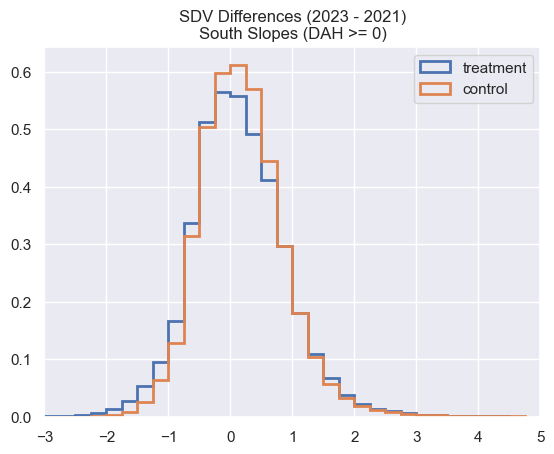

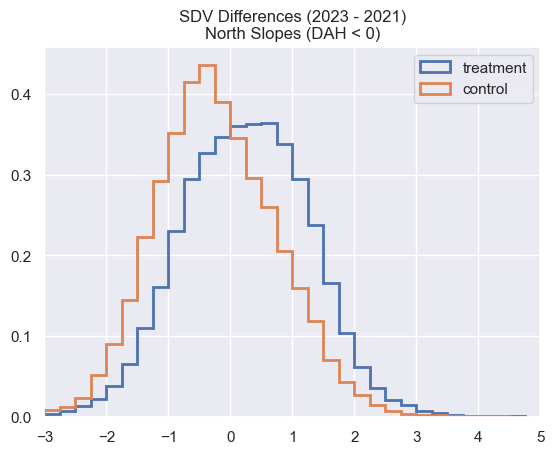

In [11]:
sdv_diff_treatments_south = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == 1)
sdv_diff_treatments_north = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == -1)
sdv_diff_control_south = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == 1)
sdv_diff_control_north = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == -1)


bins = np.arange(-3,5,0.25)

fig, ax = plt.subplots()
ax.hist(sdv_diff_treatments_south.values.ravel(), bins=bins, alpha=1, density=True, histtype='step', lw=2, label='treatment') # treatment
ax.hist(sdv_diff_control_south.values.ravel(), bins=bins, alpha=1, density=True, histtype='step', lw=2, label='control') # control
ax.set_xlim((-3,5))
plt.legend()
plt.title('SDV Differences (2023 - 2021)\nSouth Slopes (DAH >= 0)')

fig, ax = plt.subplots()
ax.hist(sdv_diff_treatments_north.values.ravel(), bins=bins, alpha=1, density=True, histtype='step', lw=2, label='treatment') # treatment
ax.hist(sdv_diff_control_north.values.ravel(), bins=bins, alpha=1, density=True, histtype='step', lw=2, label='control') # control 
ax.set_xlim((-3,5))
plt.legend()
plt.title('SDV Differences (2023 - 2021)\nNorth Slopes (DAH < 0)')



print(f'mean sdv_diff_treatments_south: ', np.round(sdv_diff_treatments_south.mean().values,2))
print(f'median sdv_diff_treatments_south: ', np.round(sdv_diff_treatments_south.median().values,2))
print(f'mean sdv_diff_treatments_north: ', np.round(sdv_diff_treatments_north.mean().values,2))
print(f'median sdv_diff_treatments_north: ', np.round(sdv_diff_treatments_north.median().values,2))
print(f'mean sdv_diff_control_south: ', np.round(sdv_diff_control_south.mean().values,2))
print(f'median sdv_diff_control_south: ', np.round(sdv_diff_control_south.median().values,2))
print(f'mean sdv_diff_control_north: ', np.round(sdv_diff_control_north.mean().values,2))
print(f'median sdv_diff_control_north: ', np.round(sdv_diff_control_north.median().values,2))

mean sdv_diff_north:  0.14
median sdv_diff_north:  0.13
mean sdv_diff_south:  0.16
median sdv_diff_south:  0.11


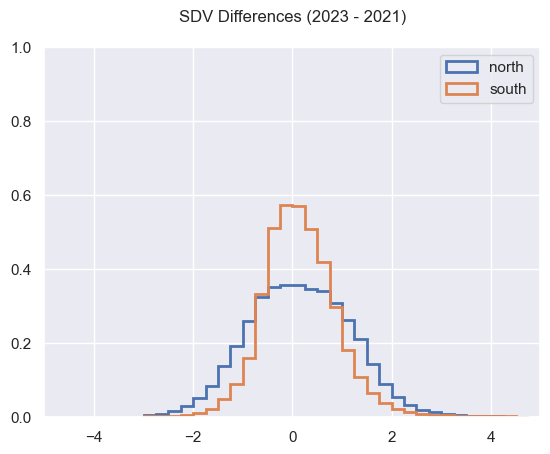

In [12]:
sdv_diff_north = ds['diff_sdv_rapid_ncalm'].where(ds.baf_ridge == -1)
sdv_diff_south = ds['diff_sdv_rapid_ncalm'].where(ds.baf_ridge == 1)


bins = np.arange(-3,5,0.25)

fig, ax = plt.subplots()
ax.hist(sdv_diff_north.values.ravel(), bins=bins, alpha=1, density=True, histtype='step', lw=2, label='north') # n
ax.hist(sdv_diff_south.values.ravel(), bins=bins, alpha=1, density=True, histtype='step', lw=2, label='south') # s
ax.set_xlim((-3,5))
plt.legend()
plt.title('SDV Differences (2023 - 2021)\n')

ax.set_ylim((0,1))
ax.set_xlim((-5,5))

print(f'mean sdv_diff_north: ', np.round(sdv_diff_north.mean().values,2))
print(f'median sdv_diff_north: ', np.round(sdv_diff_north.median().values,2))
print(f'mean sdv_diff_south: ', np.round(sdv_diff_south.mean().values,2))
print(f'median sdv_diff_south: ', np.round(sdv_diff_south.median().values,2))

### Trying to put this together with my plots...

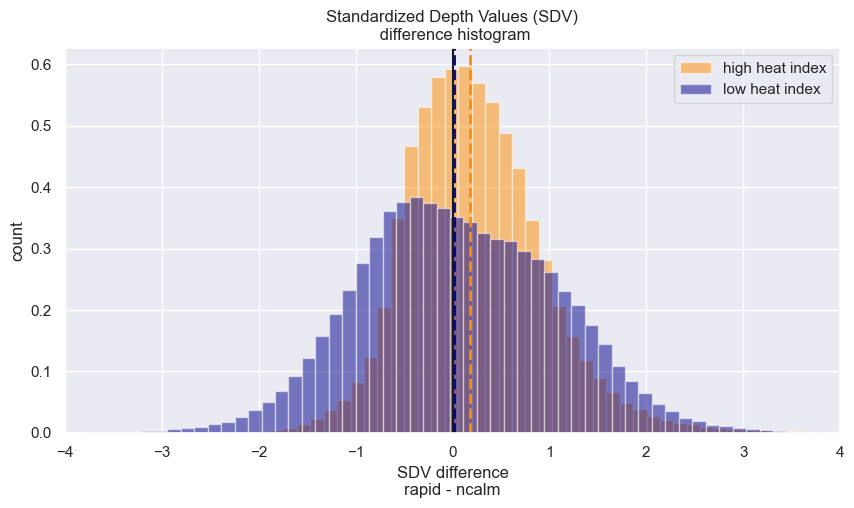

In [14]:
fig = plt.figure(figsize=(10,5))
ds['diff_sdv_rapid_ncalm'].where(ds['dah_binary'] ==  1).plot.hist(bins=100, color=colorsouth, alpha=0.5, density=True, label='high heat index');
ds['diff_sdv_rapid_ncalm'].where(ds['dah_binary'] == -1).plot.hist(bins=100, color=colornorth, alpha=0.5, density=True, label='low heat index');

# plot the median line 
plt.axvline(ds['diff_sdv_rapid_ncalm'].where(ds['dah_binary'] ==  1).median(), color=colorsouth, linestyle='dashed', linewidth=2, label='');
plt.axvline(ds['diff_sdv_rapid_ncalm'].where(ds['dah_binary'] == -1).median(), color=colornorth, linestyle='dashed', linewidth=2, label='');
plt.axvline(0,c='k')

# constants
# plt.legend(loc=(1.02,.5));
plt.legend()

plt.xlim(-4,4);
plt.ylabel('count')
plt.xlabel('SDV difference\nrapid - ncalm')

plt.title('Standardized Depth Values (SDV)\n difference histogram')
plt.show()

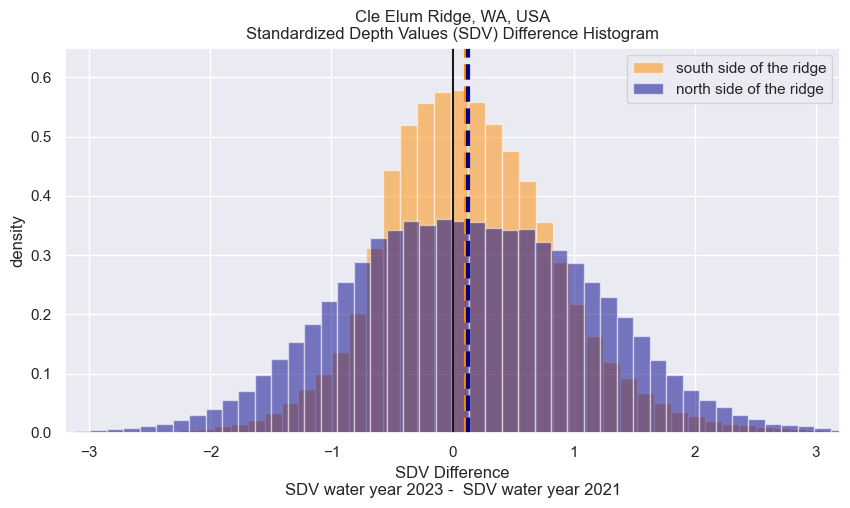

In [19]:
fig = plt.figure(figsize=(10,5))
ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] ==  1).plot.hist(bins=100, color=colorsouth, alpha=0.5, density=True, label='south side of the ridge');
ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] == -1).plot.hist(bins=100, color=colornorth, alpha=0.5, density=True, label='north side of the ridge');

# plot the median line 
plt.axvline(ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] ==  1).median(), color=colorsouth, linestyle='dashed', linewidth=3, label='');
plt.axvline(ds['diff_sdv_rapid_ncalm'].where(ds['baf_ridge'] == -1).median(), color=colornorth, linestyle='dashed', linewidth=3, label='');
plt.axvline(0,c='k')

# constants
# plt.legend(loc=(1.02,.5));
plt.legend()

# plt.xlim(-4,4);
plt.xlim(-3.2,3.2);

plt.ylim(0,0.65)
plt.ylabel('density')
plt.xlabel('SDV Difference\nSDV water year 2023 -  SDV water year 2021')

plt.title('Cle Elum Ridge, WA, USA\nStandardized Depth Values (SDV) Difference Histogram')

# export the figure with high resolution
figure_name = 'diff_SDV_side_of_ridge.png'
plt.savefig(figure_path + figure_name, dpi=500)

Now, north and south by treated and untreated areas

In [21]:
ds['sdv_diff_treatment_south'] = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_treatment_north'] = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == -1)
ds['sdv_diff_control_south']   = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_control_north']   = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == -1)

In [38]:
colorcontrol = 'black'
colortreatment = 'saddlebrown'

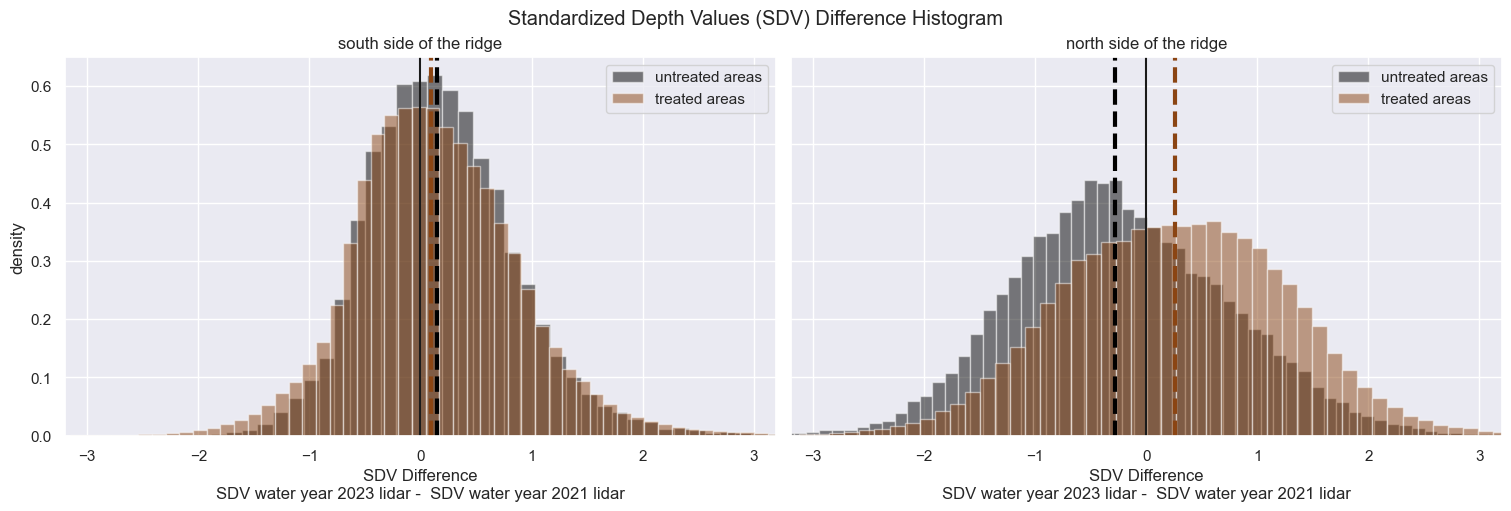

In [39]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,5), constrained_layout = True)
ds['sdv_diff_control_south'].plot.hist(ax=axes[0], bins=100, color=colorcontrol, alpha=0.5, density=True, label='untreated areas');
ds['sdv_diff_treatment_south'].plot.hist(ax=axes[0], bins=100, color=colortreatment, alpha=0.5, density=True, label='treated areas');
ds['sdv_diff_control_north'].plot.hist(ax=axes[1], bins=100, color=colorcontrol, alpha=0.5, density=True, label='untreated areas');
ds['sdv_diff_treatment_north'].plot.hist(ax=axes[1], bins=100, color=colortreatment, alpha=0.5, density=True, label='treated areas');

# plot the median line 
axes[0].axvline(ds['sdv_diff_control_south'].median(), color=colorcontrol, linestyle='dashed', linewidth=3, label='');
axes[0].axvline(ds['sdv_diff_treatment_south'].median(), color=colortreatment, linestyle='dashed', linewidth=3, label='');
axes[1].axvline(ds['sdv_diff_control_north'].median(), color=colorcontrol, linestyle='dashed', linewidth=3, label='');
axes[1].axvline(ds['sdv_diff_treatment_north'].median(), color=colortreatment, linestyle='dashed', linewidth=3, label='');

axes[0].axvline(0,c='k');axes[1].axvline(0,c='k')

# constants
# axes[0].legend(loc=(1.02,.5));
axes[0].legend()
axes[1].legend()

axes[0].set_ylim(0,0.65);
axes[0].set_xlim(-3.2,3.2);
axes[0].set_ylabel('density')
axes[0].set_xlabel('SDV Difference\nSDV water year 2023 lidar -  SDV water year 2021 lidar')
axes[1].set_xlabel('SDV Difference\nSDV water year 2023 lidar -  SDV water year 2021 lidar')

plt.suptitle('Standardized Depth Values (SDV) Difference Histogram')
axes[0].set_title('south side of the ridge')
axes[1].set_title('north side of the ridge')

plt.show()

Try to plot a figure with the untreated and treated areas...

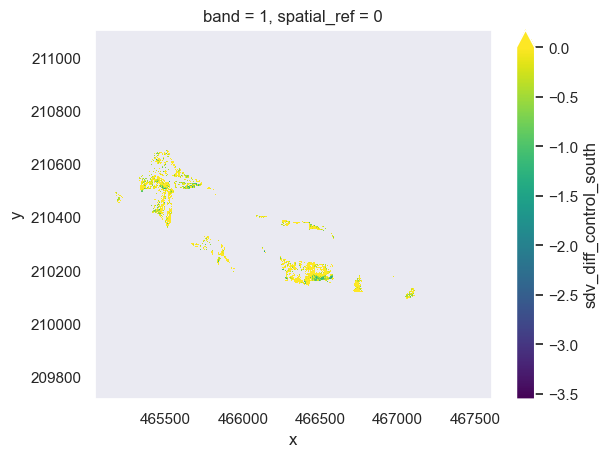

In [44]:
ds['sdv_diff_control_south'].plot(vmax=0)

In [ ]:
# okay I did not finish this, but if I want to add the figures for the locations on the SVD figure, then I'll need to get these 
# datasets into binary datasets for the control and treatment areas on the north and south sides of the ridge 

# ds['sdv_diff_treatment_south'] = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == 1)
# ds['sdv_diff_treatment_north'] = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == -1)
# ds['sdv_diff_control_south']   = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == 1)
# ds['sdv_diff_control_north']   = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == -1)

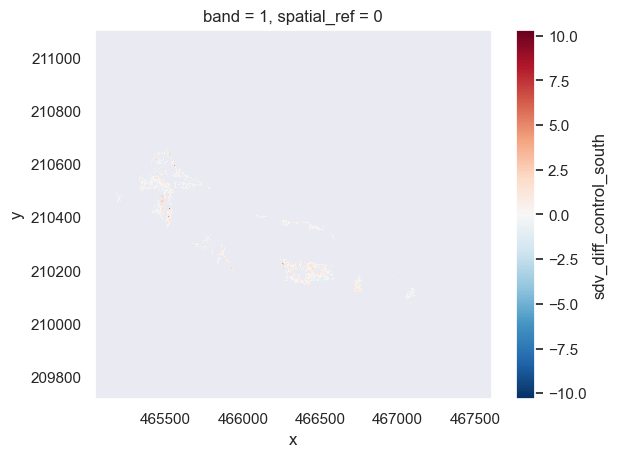

In [40]:
plt.figure(figsize=(4,4), constrained_layout = True)

# plot 3
ds['sdv_diff_control_south'].plot(vmin=0, vmax=1, cmap=ListedColormap(['navy','orange']), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {"orange": "south side of the ridge road",
                "navy": "north side of the ridge road"}                 

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

plt.legend(handles=patches2,
          bbox_to_anchor=(1, 1),
          facecolor="white")

plt.title('binary side of the ridge')

plt.xlabel('');plt.ylabel('');plt.xticks([]);plt.yticks([])

# export the figure with high resolution
figure_name = 'side_of_ridge.png'
plt.savefig(figure_path + figure_name, dpi=500)

plt.show()

Now, north and south with small heat index differences too

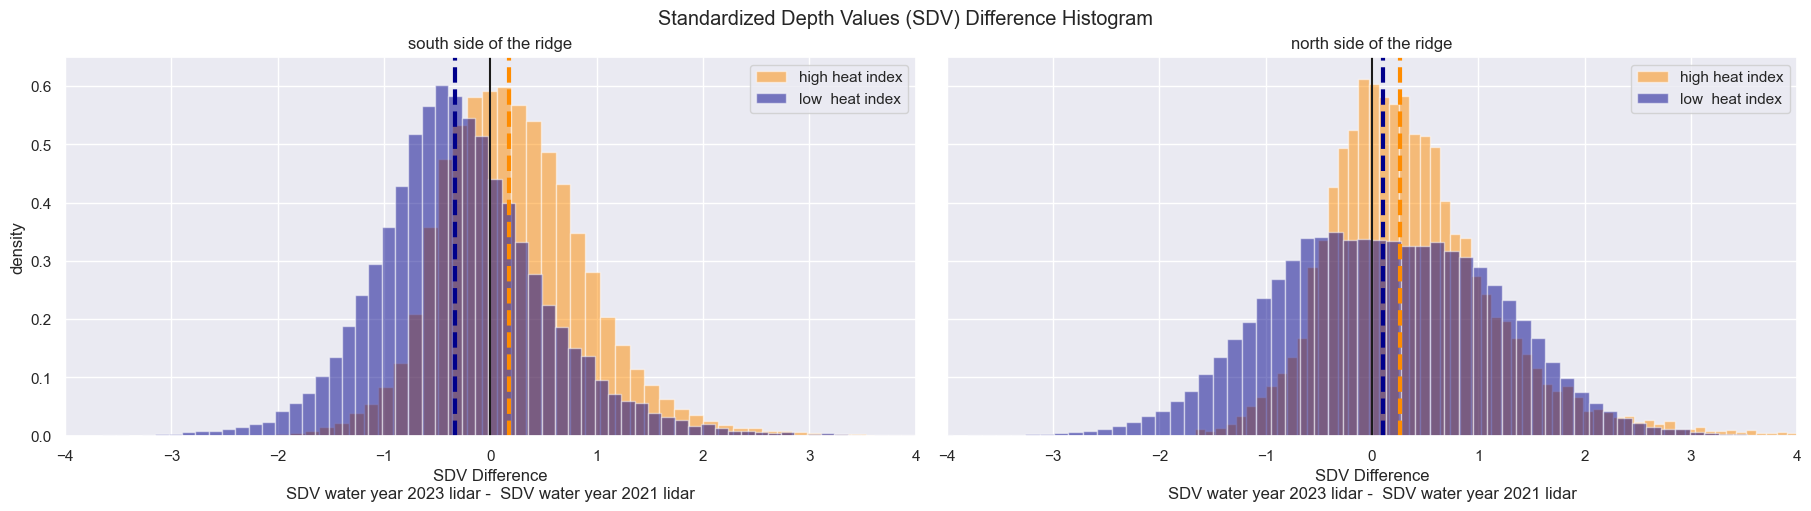

In [18]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(18,5), constrained_layout = True)
ds['diff_sdv_rapid_ncalm'].where((ds['baf_ridge'] ==  1)  & (ds['dah_binary'] ==  1)).plot.hist(ax=axes[0], bins=100, color=colorsouth, alpha=0.5, density=True, label='high heat index');
ds['diff_sdv_rapid_ncalm'].where((ds['baf_ridge'] ==  1)  & (ds['dah_binary'] == -1)).plot.hist(ax=axes[0], bins=100, color=colornorth, alpha=0.5, density=True, label='low  heat index');
ds['diff_sdv_rapid_ncalm'].where((ds['baf_ridge'] ==  -1) & (ds['dah_binary'] ==  1)).plot.hist(ax=axes[1], bins=100, color=colorsouth, alpha=0.5, density=True, label='high heat index');
ds['diff_sdv_rapid_ncalm'].where((ds['baf_ridge'] ==  -1) & (ds['dah_binary'] == -1)).plot.hist(ax=axes[1], bins=100, color=colornorth, alpha=0.5, density=True, label='low  heat index');

# plot the median line 
axes[0].axvline(ds['diff_sdv_rapid_ncalm'].where((ds['baf_ridge'] ==  1)  & (ds['dah_binary'] ==  1)).median(), color=colorsouth, linestyle='dashed', linewidth=3, label='');
axes[0].axvline(ds['diff_sdv_rapid_ncalm'].where((ds['baf_ridge'] ==  1)  & (ds['dah_binary'] == -1)).median(), color=colornorth, linestyle='dashed', linewidth=3, label='');
axes[1].axvline(ds['diff_sdv_rapid_ncalm'].where((ds['baf_ridge'] ==  -1) & (ds['dah_binary'] ==  1)).median(), color=colorsouth, linestyle='dashed', linewidth=3, label='');
axes[1].axvline(ds['diff_sdv_rapid_ncalm'].where((ds['baf_ridge'] ==  -1) & (ds['dah_binary'] == -1)).median(), color=colornorth, linestyle='dashed', linewidth=3, label='');

axes[0].axvline(0,c='k');axes[1].axvline(0,c='k')

# constants
# axes[0].legend(loc=(1.02,.5));
axes[0].legend()
axes[1].legend()

axes[0].set_ylim(0,0.65);
axes[0].set_xlim(-4,4);
axes[0].set_ylabel('density')
axes[0].set_xlabel('SDV Difference\nSDV water year 2023 lidar -  SDV water year 2021 lidar')
axes[1].set_xlabel('SDV Difference\nSDV water year 2023 lidar -  SDV water year 2021 lidar')

plt.suptitle('Standardized Depth Values (SDV) Difference Histogram')
axes[0].set_title('south side of the ridge')
axes[1].set_title('north side of the ridge')

plt.show()